## Import Needed Modules

In [2]:
import numpy as np
import pandas as pd
import missingno as msno
import sklearn.ensemble
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import category_encoders as ce
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
plt.style.use('ggplot')

## Data Exploration
Handling Missing Data

In [3]:
test=pd.read_csv('test.csv')

In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
print(test.shape)


(1459, 80)


Comibine Features

In [6]:
X=test
X.reset_index(drop=True,inplace=True)
print(X.shape)
X.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Find columns with the most missing data with respect to the size of the test data.

Text(0, 0.5, 'Missingness %')

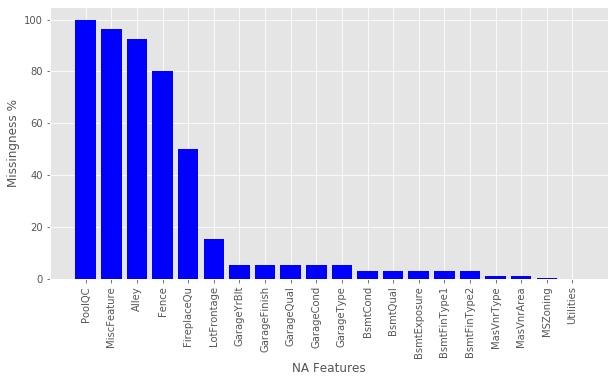

In [7]:
NaNcols=X.isna().sum()/X.shape[0]*100
a,b=zip(*sorted(zip(NaNcols.index,NaNcols),key=lambda t:t[1],reverse=True)[:20])
plt.rcParams['figure.figsize'] = (10,5)
plt.bar(a,b,color='b')
plt.xticks(rotation='vertical')
plt.xlabel('NA Features')
plt.ylabel('Missingness %')

- 99.5% of **PoolQC** is missing
- 96.3% of **MiscFeature** is missing
- 93.7% of **Alley** is missing
- 80.7% of **Fence** is missing
- 47.2% of **FireplaceQu** is missing

These data are missing because some features do not exist in some houses. So, the actual values will be imputed as they are referenced in the data description file.

In [8]:
X['PoolQC'].fillna('No Pool',inplace=True)
X['MiscFeature'].fillna('None',inplace=True)
X['Alley'].fillna('No alley access',inplace=True)
X['Fence'].fillna('No Fence',inplace=True)
X['FireplaceQu'].fillna('No Fireplace',inplace=True)

X['GarageType'].fillna('No Garage',inplace=True)
X['GarageFinish'].fillna('No Garage',inplace=True)
X['GarageQual'].fillna('No Garage',inplace=True)

X['BsmtExposure'].fillna('No Basement',inplace=True)
X['BsmtFinType1'].fillna('No Basement',inplace=True)
X['BsmtFinType2'].fillna('No Basement',inplace=True)
X['BsmtQual'].fillna('No Basement',inplace=True)
X['BsmtCond'].fillna('No Basement',inplace=True)
X['GarageCond'].fillna('No Garage',inplace=True)

Since, the year in which the garage was built has about 5% missing data, and we cannot assume that the year is zero if there is not a garage, we will try to get rid of the column but after checking the correlation with the year in which the house is built.
The year the garage is built and the year the house is built are highly correlated. therefore, he year the garage is built will be removed from the data. And, another parameter for Garage will be added (1= there's a garage, 0=No garage).

[[1.      0.84415]
 [0.84415 1.     ]]


Text(0, 0.5, 'Year House Built')

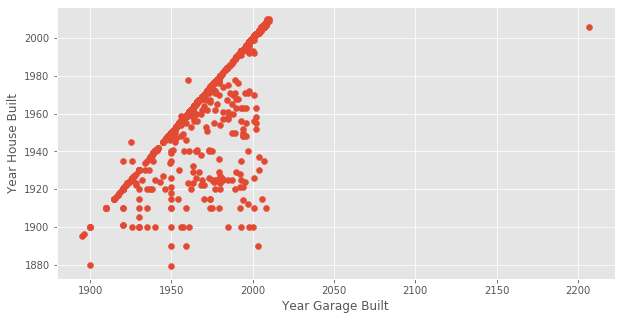

In [9]:
garage_year=pd.DataFrame({'GarageYrBlt':X['GarageYrBlt'],'YearBuilt':X['YearBuilt']})
garage_year.dropna(inplace=True)
garage_year
plt.scatter(garage_year['GarageYrBlt'],garage_year['YearBuilt'])
print(np.corrcoef(garage_year['GarageYrBlt'],garage_year['YearBuilt']))
plt.xlabel('Year Garage Built')
plt.ylabel('Year House Built')

In [10]:
X.drop('GarageYrBlt',axis=1,inplace=True)
X['Garage']=X['GarageType'].apply(lambda x: 0 if x=='No Garage' else 1)

Text(0, 0.5, 'Missingness %')

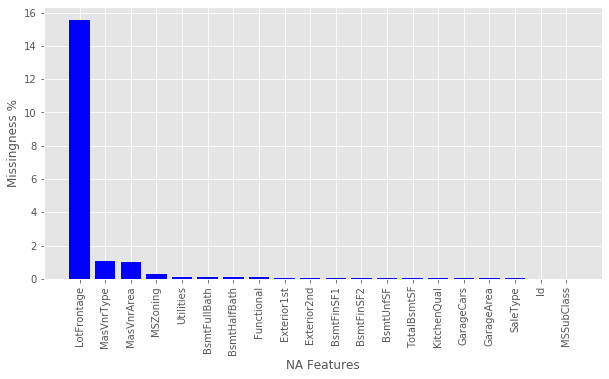

In [11]:
NaNcols=X.isna().sum()/X.shape[0]*100
a,b=zip(*sorted(zip(NaNcols.index,NaNcols),key=lambda t:t[1],reverse=True)[:20])
plt.rcParams['figure.figsize'] = (10,5)
plt.bar(a,b,color='b')
plt.xticks(rotation='vertical')
plt.xlabel('NA Features')
plt.ylabel('Missingness %')

After imputing the true values of NA in the features set, we still have 17% of the data missing.

In [12]:
(X.shape[0]-X.dropna().shape[0])/X.shape[0]

0.1706648389307745

The missing percentage in MasVnrType and MasVnrArea are almost the same. We will see if there's a correlation between them.

Text(0, 0.5, 'Missingness %')

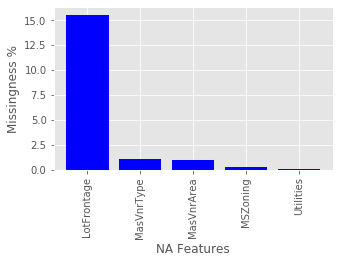

In [13]:
NaNcols=X.isna().sum()/X.shape[0]*100
a,b=zip(*sorted(zip(NaNcols.index,NaNcols),key=lambda t:t[1],reverse=True)[:5])
plt.rcParams['figure.figsize'] = (5,3)
plt.bar(a,b,color='b')
plt.xticks(rotation='vertical')
plt.xlabel('NA Features')
plt.ylabel('Missingness %')

Check the correlation between missing data using a heat map.
- Missing data are definitely the same in GarageCars and GarageArea.
- Missing data are definitely the same in BsmtFullBath and BsmtHalfBath.
- Missing data are definitely the same in TotalBsmtSF, BsmtUnfSF and BsmtFinSF2.
- Missing data are definitely the same in Exterior1st and Exterior2nd.
- Missing data are almost the same in MasVnrArea and MasVnrType

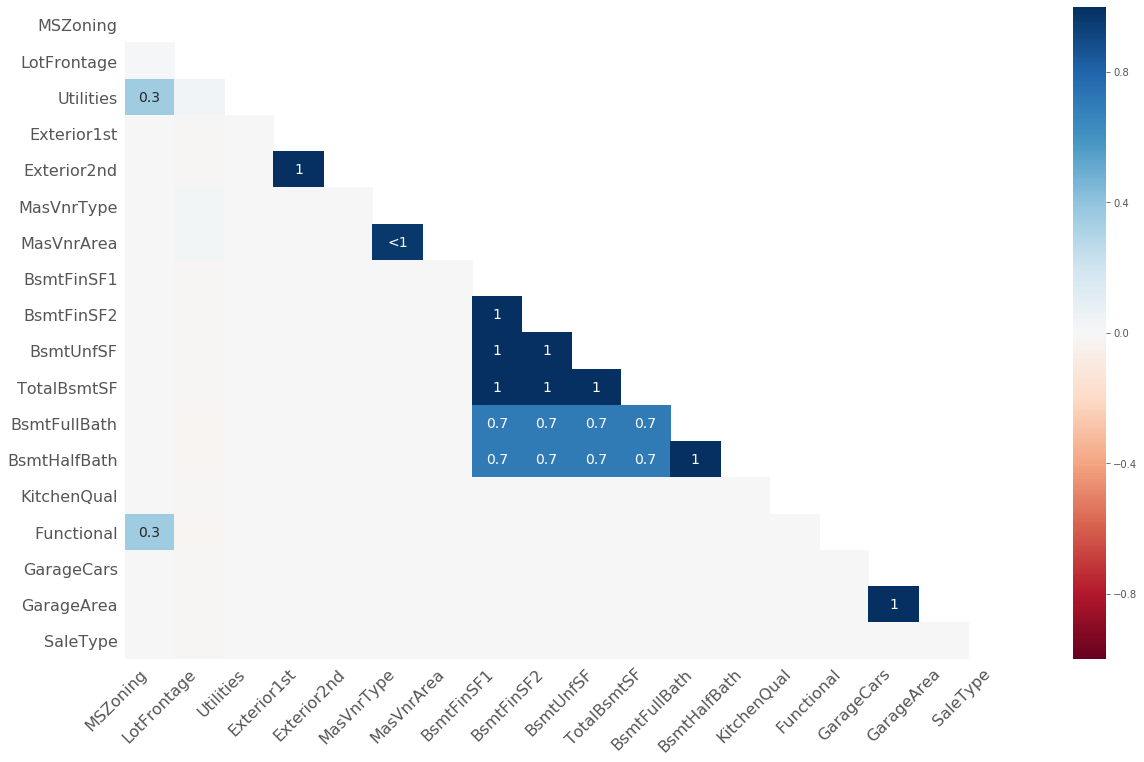

In [14]:
msno.heatmap(X)

The missing value in GarageCars and GarageArea have 1 in the Garage column. This house will be imputed as 0.

In [15]:
X['Garage'].loc[X['GarageCars'].isna()]

1116    1
Name: Garage, dtype: int64

In [16]:
X['GarageCars'].fillna(0,inplace=True)
X['GarageArea'].fillna(0,inplace=True)

The houses that have BsmtFullBath and BsmtHalfBath missing are reported to have no basements. These values will be imputed as 0.

In [17]:
X['BsmtFinType1'].loc[X['BsmtFullBath'].isna()]

660    No Basement
728    No Basement
Name: BsmtFinType1, dtype: object

In [18]:
X['BsmtFullBath'].fillna(0,inplace=True)
X['BsmtHalfBath'].fillna(0,inplace=True)

The houses that have TotalBsmtSF, BsmtUnfSF and BsmtFinSF2 missing are reported to have no basement. These values will be impued as 0.

In [19]:
X['BsmtFinType1'].loc[X['TotalBsmtSF'].isna()]

660    No Basement
Name: BsmtFinType1, dtype: object

In [20]:
X['TotalBsmtSF'].fillna(0,inplace=True)
X['BsmtUnfSF'].fillna(0,inplace=True)
X['BsmtFinSF2'].fillna(0,inplace=True)
X['BsmtFinSF1'].fillna(0,inplace=True)

Impute Exterior1st and Exterior2nd as "Other"

In [21]:
X['Exterior1st'].fillna('Other',inplace=True)
X['Exterior2nd'].fillna('Other',inplace=True)

MasVnrArea is mostly NaN when when MasVnrType is missing. MasVnrType will be imputed as "None" and "MasVnrArea"will be imputed as "0".

In [22]:
X['MasVnrArea'].loc[X['MasVnrType'].isna()]

231       NaN
246       NaN
422       NaN
532       NaN
544       NaN
581       NaN
851       NaN
865       NaN
880       NaN
889       NaN
908       NaN
1132      NaN
1150    198.0
1197      NaN
1226      NaN
1402      NaN
Name: MasVnrArea, dtype: float64

In [23]:
X['MasVnrType'].loc[X['MasVnrType'].isna()]

231     NaN
246     NaN
422     NaN
532     NaN
544     NaN
581     NaN
851     NaN
865     NaN
880     NaN
889     NaN
908     NaN
1132    NaN
1150    NaN
1197    NaN
1226    NaN
1402    NaN
Name: MasVnrType, dtype: object

For these missing observations. MasVnrType will be imputed as "None" and "MasVnrArea"will be imputed as "0".

In [24]:
X['MasVnrType'].fillna('None',inplace=True)
X['MasVnrArea'].fillna(0,inplace=True)

- Impute NA in SaleType as "Other".
- Impute NA in KitchenQual as "Average"
- Impute NA in Functional as "Mod" (Moderate)
- Impute NA in Utilities as "AllPub" (All Public Utilities)
- Impute NA in MSZoning as "RM" (Residential Medium Density)

In [25]:
X['SaleType'].fillna('Other',inplace=True)
X['KitchenQual'].fillna('Average',inplace=True)
X['Functional'].fillna('Mod',inplace=True)
X['Utilities'].fillna('AllPub',inplace=True)
X['MSZoning'].fillna('RM',inplace=True)

Now, we have 17.5% of the data missing in LotFrontage. There's only one missing value in Electrical, and we will drop it.

We will use KNN neighbor to impute the missing values.

Text(0, 0.5, 'Missingness %')

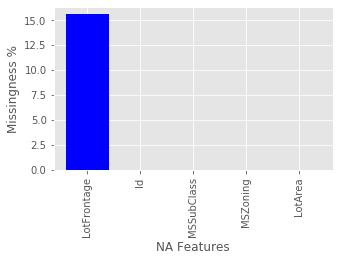

In [26]:
NaNcols=X.isna().sum()/X.shape[0]*100
a,b=zip(*sorted(zip(NaNcols.index,NaNcols),key=lambda t:t[1],reverse=True)[:5])
plt.rcParams['figure.figsize'] = (5,3)
plt.bar(a,b,color='b')
plt.xticks(rotation='vertical')
plt.xlabel('NA Features')
plt.ylabel('Missingness %')

In order to use Gower distance and for decision tree purposes, we need to start encoding ordinal features because Gower can handle categorical features as they are.

Split categorical and ordinal features.

In [27]:
string_features=X.select_dtypes('object').columns
ordered_features=np.array(['LotShape','LandSlope','ExterQual', 'ExterCond',
                 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                 'HeatingQC','KitchenQual','Functional', 'FireplaceQu',
                 'GarageFinish', 'GarageQual', 'GarageCond',
                 'PoolQC','Fence'])
categ_features=np.array(['MSZoning','Street','Alley','LandContour',
               'Utilities','LotConfig','Neighborhood',
               'Condition1','Condition2','BldgType','HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                'Exterior2nd', 'MasVnrType','Foundation','Heating',
               'CentralAir', 'Electrical','GarageType','PavedDrive',
               'MiscFeature','SaleType','SaleCondition'])
# Keep the Id and SalePrice columns from the numerical features.
numerical_features=X.select_dtypes('number').columns
print(string_features.shape)
print(ordered_features.shape)
print(categ_features.shape)
print(numerical_features.shape)
print(X.shape)
#np.setdiff1d(string_features,np.union1d(ordered_features,categ_features))

(43,)
(18,)
(25,)
(37,)
(1459, 80)


In [28]:
numerical_features

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'Garage'],
      dtype='object')

Check the unique values in the categ_features.

In [29]:
for name in categ_features:
    print(name,X[name].unique())

MSZoning ['RH' 'RL' 'RM' 'FV' 'C (all)']
Street ['Pave' 'Grvl']
Alley ['No alley access' 'Pave' 'Grvl']
LandContour ['Lvl' 'HLS' 'Bnk' 'Low']
Utilities ['AllPub']
LotConfig ['Inside' 'Corner' 'FR2' 'CulDSac' 'FR3']
Neighborhood ['NAmes' 'Gilbert' 'StoneBr' 'BrDale' 'NPkVill' 'NridgHt' 'Blmngtn'
 'NoRidge' 'Somerst' 'SawyerW' 'Sawyer' 'NWAmes' 'OldTown' 'BrkSide'
 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor' 'Blueste' 'IDOTRR'
 'Mitchel' 'Timber' 'MeadowV' 'Veenker']
Condition1 ['Feedr' 'Norm' 'PosN' 'RRNe' 'Artery' 'RRNn' 'PosA' 'RRAn' 'RRAe']
Condition2 ['Norm' 'Feedr' 'PosA' 'PosN' 'Artery']
BldgType ['1Fam' 'TwnhsE' 'Twnhs' 'Duplex' '2fmCon']
HouseStyle ['1Story' '2Story' 'SLvl' '1.5Fin' 'SFoyer' '2.5Unf' '1.5Unf']
RoofStyle ['Gable' 'Hip' 'Gambrel' 'Flat' 'Mansard' 'Shed']
RoofMatl ['CompShg' 'Tar&Grv' 'WdShake' 'WdShngl']
Exterior1st ['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'MetalSd' 'CemntBd' 'WdShing'
 'BrkFace' 'AsbShng' 'BrkComm' 'Stucco' 'AsphShn' 'Other' 'CBlock']
Exterio

Get unique values of the ordinal data to encode them.

In [30]:
for name in ordered_features:
    print(name,X[name].unique())

LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandSlope ['Gtl' 'Mod' 'Sev']
ExterQual ['TA' 'Gd' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual ['TA' 'Gd' 'Ex' 'Fa' 'No Basement']
BsmtCond ['TA' 'Po' 'Fa' 'Gd' 'No Basement']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' 'No Basement']
BsmtFinType1 ['Rec' 'ALQ' 'GLQ' 'Unf' 'BLQ' 'LwQ' 'No Basement']
BsmtFinType2 ['LwQ' 'Unf' 'Rec' 'BLQ' 'GLQ' 'ALQ' 'No Basement']
HeatingQC ['TA' 'Gd' 'Ex' 'Fa' 'Po']
KitchenQual ['TA' 'Gd' 'Ex' 'Fa' 'Average']
Functional ['Typ' 'Min2' 'Min1' 'Mod' 'Maj1' 'Sev' 'Maj2']
FireplaceQu ['No Fireplace' 'TA' 'Gd' 'Po' 'Fa' 'Ex']
GarageFinish ['Unf' 'Fin' 'RFn' 'No Garage']
GarageQual ['TA' 'No Garage' 'Fa' 'Gd' 'Po']
GarageCond ['TA' 'No Garage' 'Fa' 'Gd' 'Po' 'Ex']
PoolQC ['No Pool' 'Ex' 'Gd']
Fence ['MnPrv' 'No Fence' 'GdPrv' 'GdWo' 'MnWw']


Create a dictionary to map the ordinal features based on the natural order.

In [31]:
ordinal_feature_mapping=[{
    "col": "LotShape",
    "mapping": {
        'Reg': 0,
        'IR1': 1,
        'IR2': 2,
        'IR3': 3
    }}, {
    "col": "LandSlope",
    "mapping": {
        'Gtl': 0,
        'Mod': 1,
        'Sev': 2
    }}, {
    "col": "ExterQual",
    "mapping": {
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }}, {
    "col": "ExterCond",
    "mapping": {
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }}, {
    "col": "BsmtQual",
    "mapping": {
        'No Basement': 0,
        'Po': 1,
        'Fa': 2,
        'TA': 3,
        'Gd': 4,
        'Ex': 5
    }}, {
    "col": "BsmtCond",
    "mapping": {
        'No Basement': 0,
        'Po': 1,
        'Fa': 2,
        'TA': 3,
        'Gd': 4,
        'Ex': 5
    }}, {
    "col": "BsmtExposure",
    "mapping": {
        'No Basement': 0,
        'No': 1,
        'Mn': 2,
        'Av': 3,
        'Gd': 4
    }}, {
    "col": "BsmtFinType1",
    "mapping": {
        'No Basement': 0,
        'Unf': 1,
        'LwQ': 2,
        'Rec': 3,
        'BLQ': 4,
        'ALQ': 5,
        'GLQ': 6
    }}, {
    "col": "BsmtFinType2",
    "mapping": {
        'No Basement': 0,
        'Unf': 1,
        'LwQ': 2,
        'Rec': 3,
        'BLQ': 4,
        'ALQ': 5,
        'GLQ': 6   
    }}, {
    "col": "HeatingQC",
    "mapping": {
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }},{
    "col": "KitchenQual",
    "mapping": {
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }}, {
    "col": "Functional",
    "mapping": {
        'Sal': 0,
        'Sev': 1,
        'Maj2': 2,
        'Maj1': 3,
        'Mod': 4,
        'Min2': 5,
        'Min1': 6,
        'Typ': 7
    }}, {
    "col": "FireplaceQu",
    "mapping": {
        'No Fireplace': 0,
        'Po': 1,
        'Fa': 2,
        'TA': 3,
        'Gd': 4,
        'Ex': 5
    }}, {
    "col": "GarageFinish",
    "mapping": {
        'No Garage': 0,
        'Unf': 1,
        'RFn': 2,
        'Fin': 3
    }}, {
    "col": "GarageQual",
    "mapping": {
        'No Garage': 0,
        'Po': 1,
        'Fa': 2,
        'TA': 3,
        'Gd': 4,
        'Ex': 5
    }}, {
    "col": "GarageCond",
    "mapping": {
        'No Garage': 0,
        'Po': 1,
        'Fa': 2,
        'TA': 3,
        'Gd': 4,
        'Ex': 5
    }}, {
    "col": "PoolQC",
    "mapping": {
        'No Pool': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }}, {
    "col": "Fence",
    "mapping": {
        'No Fence': 0,
        'MnWw': 1,
        'GdWo': 2,
        'MnPrv': 3,
        'GdPrv': 4
    }}
]

Use the encoding dictionary to convert the ordinal features into ordered numerical values.

In [32]:
ord_encoder= ce.OrdinalEncoder(mapping = ordinal_feature_mapping, 
                             return_df = True)

In [33]:
ordered_data=ord_encoder.fit_transform(X[ordered_features])
for name in ordered_features:
    print(name,ordered_data[name].unique())
print(ordered_data.shape)

LotShape [0 1 2 3]
LandSlope [0 1 2]
ExterQual [2 3 4 1]
ExterCond [2 3 1 0 4]
BsmtQual [3 4 5 2 0]
BsmtCond [3 1 2 4 0]
BsmtExposure [1 4 2 3 0]
BsmtFinType1 [3 5 6 1 4 2 0]
BsmtFinType2 [2 1 3 4 6 5 0]
HeatingQC [2 3 4 1 0]
KitchenQual [ 2.  3.  4.  1. -1.]
Functional [7 5 6 4 3 1 2]
FireplaceQu [0 3 4 1 2 5]
GarageFinish [1 3 2 0]
GarageQual [3 0 2 4 1]
GarageCond [3 0 2 4 1 5]
PoolQC [0 4 3]
Fence [3 0 4 2 1]
(1459, 18)


We create a data set that will be used to impute mising LotFrontage area. The data is consisted of the ordinal, categorical and numerical features except 'Id'.

In [34]:
imputation_data=pd.concat([ordered_data,X[categ_features],X[numerical_features]],axis=1)

We will try imputation of **LotFrontage** in **R** using KNN and Gower's distance.

In [35]:
imputation_data.to_csv('imputation_test_set.csv')

When the method is tested on data that existed in X data set. The mean absolute error was about 9.88 feet (14.4% of the mean Lot Frontage).
The percentate of missing data is now 0 %.

In [36]:
imp=pd.read_csv('imputed_test_data.csv')
(imp.shape[0]-imp.dropna().shape[0])/imp.shape[0]*100

0.0

Some Feature names changed in R because they start with a number. Get the feature names that changes

In [37]:
np.setdiff1d(imp.columns,imputation_data.columns)

array(['LotFrontage_imp', 'X1stFlrSF', 'X2ndFlrSF', 'X3SsnPorch'],
      dtype=object)

In [38]:
imp.drop('LotFrontage_imp',axis=1,inplace=True)
imp.rename(columns={'X1stFlrSF':'1stFlrSF','X2ndFlrSF':'2ndFlrSF','X3SsnPorch':'3SsnPorch'},inplace=True)

In [39]:
np.setdiff1d(imp.columns,imputation_data.columns)

array([], dtype=object)

In [40]:
np.setdiff1d(imputation_data.columns,imp.columns)

array([], dtype=object)

Combine numerical and ordinal data in xdata

In [41]:
xdata=pd.DataFrame()
for name in ordered_features:
    xdata[name]=np.array(imp[name])
for name in numerical_features:
    xdata[name]=np.array(imp[name])
xdata.shape

(1459, 55)

## Prepare Data For Predictions

In [42]:
categ_data=pd.get_dummies(imp[categ_features],prefix=categ_features,drop_first=True)

In [43]:
categ_data.shape

(1459, 136)

Combine Categorical, Ordinal and Numeric Features in xdata.

In [44]:
xdata=pd.concat([categ_data,xdata],axis=1)
xdata.shape

(1459, 191)

Read train set and fit the model with the optimized parameters.

In [45]:
xdata_train=pd.read_csv('model_data.csv')
X_train=xdata_train.drop(['Id','SalePrice'],axis=1)
Y_train=xdata_train['SalePrice']

In [46]:
col_names=X_train.columns
col_names.shape

(200,)

In [47]:
features_test=xdata.reindex(columns=col_names,fill_value=0)
features_test.reset_index(drop=True,inplace=True)
features_test.shape

(1459, 200)

## Build the Model
Build the model and check the train error. It is similar to what's predicted from the sub-train set.

In [48]:
from sklearn.ensemble import GradientBoostingRegressor
np.random.seed(0)
gbm= GradientBoostingRegressor(n_estimators=1000,learning_rate=0.005,verbose=False,max_depth=5,max_features=25)
gbm.fit(X_train,Y_train)
y_train_predict=gbm.predict(X_train)
print('MAPE train= ',np.mean(np.abs((Y_train - y_train_predict) / Y_train)) * 100,'%')


MAPE train=  5.7412121158810505 %


The Root Mean Squared Logarithmic Error (RMSLE) is 0.081

In [49]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error( Y_train, y_train_predict ))

0.08093710112044808

## Predictions of the Test Set

In [51]:
Ytest_predicted=gbm.predict(features_test)

In [53]:
preds=pd.DataFrame()
preds['Id']=X['Id']
preds['SalePrice']=Ytest_predicted
preds.reset_index(drop=True,inplace=True)
preds.head()

,Id,SalePrice
0,1461,123805.564519
1,1462,156538.826198
2,1463,186016.055856
3,1464,189955.443668
4,1465,192199.871837


In [54]:
preds.isna().sum()

Id           0
SalePrice    0
dtype: int64

In [89]:
preds.to_csv('predictions_ia.csv',index=False)

#### The RMSLE of the test set reported by Kaggle is 0.134 as compared to 0.081 from the train set. Both errors have close magnitudes, the difference and the errors are acceptable.